## Import library

In [57]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("resume.csv")

In [58]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[0:200, ]  #optional if your computer is fast, no need
df_resume.shape

(200, 4)

## 2. Load skill data

In [59]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "skills.jsonl"

In [60]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [61]:
doc = nlp("Chaky loves deep learning.")
doc.ents

(Chaky, deep learning)

##  3. Let's try to extract skills from this resume .csv

In [62]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1045,18368613,Z SALES CONSULTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",SALES
2064,27000192,"VP, PUBLIC RELATIONS ACCOUNT DIRECTOR...","<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS
758,85417107,HIRING MANAGER/RECRUITING MANAGER ...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
97,27496514,HR CUSTOMER SERVICE REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",HR
274,18176523,SENIOR INFORMATION TECHNOLOGY MANAGER...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY


In [63]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):
    
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

In [64]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         INFORMATION TECHNOLOGY INTERN (TEST AUTOMATION ENGINEER)       Summary      Over 3 years\xa0of experience serving as a key contributor across all software development life cycle\xa0phases including\xa0analysis, architectural design, prototyping, development, and testing of application\xa0using Java/J2E'

In [65]:
preprocessing(random_resume[:300])

'information technology intern test automation engineer summary over 3 year experience serve key contributor software development life cycle phase include analysis architectural design prototyping development testing application java j2e'

In [66]:
#let's apply to the whole dataframe
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

## 4. extract the skills

In [67]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text)  #note that this nlp already know skills
    
    skills = []
    
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == "SKILL":
            skills.append(ent.text)
    
    return skills

def unique_skills(x):
    return list(set(x))

In [68]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
1045,18368613,Z SALES CONSULTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",SALES,z sales consultant summary highly motivated co...


In [69]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)


In [70]:
df_resume.Skills.iloc[0]

['business', 'marketing', 'server', 'business intelligence', 'support']

## 5. Visualization

In [71]:
set(df_resume.Category)


{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [72]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(11, 6)

In [73]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [74]:
#counting
from collections import Counter, OrderedDict

counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [75]:
counting

OrderedDict([('support', 11),
             ('software', 9),
             ('security', 9),
             ('business', 8),
             ('design', 8),
             ('server', 7),
             ('database', 7),
             ('project management', 7),
             ('specification', 6),
             ('linux', 5)])

<BarContainer object of 10 artists>

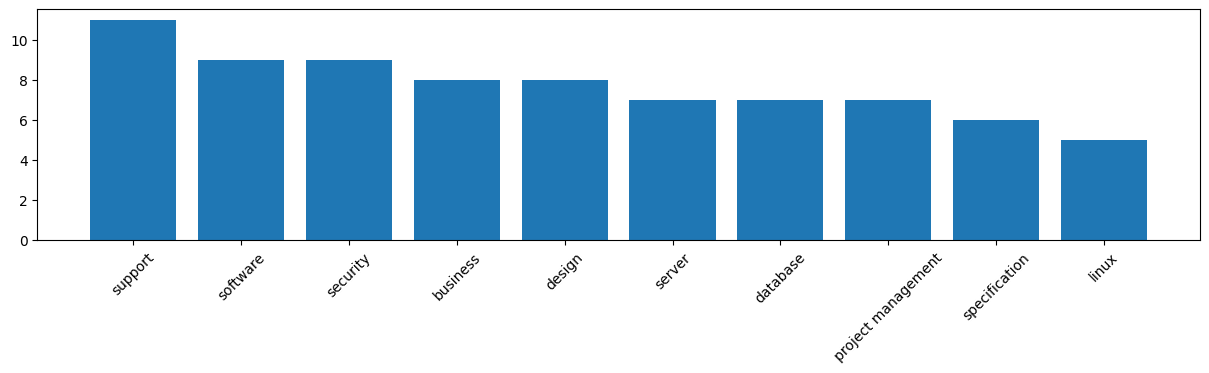

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation =45)

plt.bar(counting.keys(), counting.values())

## 6.Name Entity recognization

In [78]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[10]

In [79]:
doc = nlp(text)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [80]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

## 7. load the PDF

In [81]:
from PyPDF2 import PdfReader
#pip install PyPDF2

reader = PdfReader("someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [82]:
text = preprocessing(text)

In [85]:
doc = nlp(text)

In [86]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", options=options)

In [84]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []

for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)
        
print(set(skills))


{'business', 'interaction', 'server', 'database', 'deployment', 'mobile computing', 'project management', 'security', 'documentation', 'telephony', 'performance metric', 'help desk', 'design', 'monitoring', 'support', 'analytics', 'mobile', 'network security', 'software', 'framework', 'windows'}
